# Code to perform bootstrapping on MMLA test dataset
Compare performance of finetuned and baseline YOLOv11m model

In [1]:
# import libraries 
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from ultralytics import YOLO
import os
import shutil
import numpy as np
from pathlib import Path
import random
from tqdm import tqdm
from PIL import Image
from collections import defaultdict

# Get inference results for test dataset from both models

In [2]:
# Load both models
finetuned = YOLO("/fs/ess/PAS2136/Kenya-2023/yolo_benchmark/HerdYOLO/runs/detect/train4/weights/best.pt")
baseline = YOLO("/fs/ess/PAS2136/Kenya-2023/yolo_benchmark/HerdYOLO/yolo11m.pt")

In [3]:
# Define path to the test images and labels
full_img_dir = Path("/fs/ess/PAS2136/Kenya-2023/yolo_benchmark/HerdYOLO/data/images/test")
full_lbl_dir = Path("/fs/ess/PAS2136/Kenya-2023/yolo_benchmark/HerdYOLO/data/labels/test")
all_imgs = list(full_img_dir.glob("*.jpg"))  # or .png depending on your dataset
n_samples = len(all_imgs)

In [4]:
# Define functions to read ground truth bounding boxes and get predicted bounding boxes

def read_ground_truth_bbox(label_path, image_path):
    
    """
    Reads YOLO-format ground truth bounding boxes and converts them to (x1, y1, x2, y2) pixel coordinates.
    
    :param label_path: Path to YOLO label .txt file
    :param image_path: Corresponding image path (to get width & height)
    :return: Numpy array of shape (N, 4) with bounding boxes in pixel coordinates
    """
    # Load image to get dimensions
    with Image.open(image_path) as img:
        img_width, img_height = img.size

    classes = []
    bboxes = []
    with open(label_path, 'r') as f:
        lines = f.readlines()

    for line in lines:
        parts = line.strip().split()
        if len(parts) == 5:
            class_id, x_c, y_c, w, h = map(float, parts)
            # Convert from normalized to absolute pixel coordinates
            x_center = x_c * img_width
            y_center = y_c * img_height
            width = w * img_width
            height = h * img_height

            x1 = x_center - width / 2
            y1 = y_center - height / 2
            x2 = x_center + width / 2
            y2 = y_center + height / 2

            bboxes.append([x1, y1, x2, y2])
            
            classes.append(int(class_id))

    return np.array(bboxes), classes

def get_pred_bboxes(model, img_path):
    """
    Get predicted bounding boxes from the model.
    
    :param model: YOLO model
    :param img_path: Path to the image
    :return: Numpy array of shape (N, 4) with bounding boxes in pixel coordinates
    """
    results = model.predict(img_path, conf=0.25)
    predictions = results[0].boxes.data.cpu().numpy()
    
    bboxes = []
    for pred in predictions:
        x1, y1, x2, y2 = pred.xyxy[0]
        bboxes.append([x1.item(), y1.item(), x2.item(), y2.item()])
    
    return np.array(bboxes)

def calculate_iou(box1, box2):
    """
    Calculate IoU between two boxes (x1, y1, x2, y2)
    """
    # Calculate intersection coordinates
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    
    # Check if boxes overlap
    if x2 <= x1 or y2 <= y1:
        return 0.0
        
    # Calculate areas
    intersection_area = (x2 - x1) * (y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area
    
    # Calculate IoU
    return intersection_area / union_area

def compute_iou_matrix(boxes1, boxes2):
    iou_matrix = np.zeros((len(boxes1), len(boxes2)))
    for i, box1 in enumerate(boxes1):
        for j, box2 in enumerate(boxes2):
            iou_matrix[i, j] = calculate_iou(box1, box2)
    return iou_matrix

def compute_classwise_metrics(pred_boxes, pred_classes, gt_boxes, gt_classes, iou_thresh=0.5):
    """
    Computes TP, FP, FN, Precision, Recall, F1 and mean IoU per class.
    :param pred_boxes: Nx4 or Nx6 array of predicted boxes (if Nx6, only first 4 values are used)
    :param pred_classes: N array of predicted class ids
    :param gt_boxes: Mx4 array of ground truth boxes
    :param gt_classes: M array of ground truth class ids
    :return: dict per class with TP, FP, FN, mean_iou, precision, recall, f1, N
    """
    from collections import defaultdict
    
    class_results = defaultdict(lambda: {"TP": 0, "FP": 0, "FN": 0, "matched_ious": [], "avg_iou": 0.0, "precision": 0.0, "recall": 0.0, "f1": 0.0})

    all_classes = set(pred_classes).union(set(gt_classes))
    
    print(f"Classes in predictions: {set(pred_classes)}")

    for cls in all_classes:
        # Extract boxes for this class, ensuring we only use the first 4 values
        cls_pred = [b[:4] for b, c in zip(pred_boxes, pred_classes) if c == cls]
        print(f"Predicted boxes for class {cls}: {cls_pred}")
        cls_gt = [b[:4] for b, c in zip(gt_boxes, gt_classes) if c == cls]
        print(f"Ground truth boxes for class {cls}: {cls_gt}")

        matched_gt = set()
        matched_pred = set()
        matched_ious = []

        iou_matrix = compute_iou_matrix(cls_pred, cls_gt)

        # Sort all pred-gt pairs by IoU in descending order
        pairs = []
        for pred_idx in range(len(cls_pred)):
            for gt_idx in range(len(cls_gt)):
                iou = iou_matrix[pred_idx, gt_idx]
                if iou >= iou_thresh:
                    pairs.append((pred_idx, gt_idx, iou))
        
        # Sort by IoU (descending)
        pairs.sort(key=lambda x: x[2], reverse=True)
        
        # Match in order of decreasing IoU
        for pred_idx, gt_idx, iou in pairs:
            if pred_idx not in matched_pred and gt_idx not in matched_gt:
                matched_gt.add(gt_idx)
                matched_pred.add(pred_idx)
                matched_ious.append(iou)
                
        Avg_IoU = np.mean(matched_ious) if matched_ious else 0.0

        TP = len(matched_ious)
        FP = len(cls_pred) - TP
        FN = len(cls_gt) - TP
        P = TP / (TP + FP) if (TP + FP) > 0 else 0
        R = TP / (TP + FN) if (TP + FN) > 0 else 0
        F1 = 2 * (P * R) / (P + R) if (P + R) > 0 else 0
        N = len(cls_gt)
        

        class_results[cls]["TP"] += TP
        class_results[cls]["FP"] += FP
        class_results[cls]["FN"] += FN
        class_results[cls]["avg_iou"] = Avg_IoU
        class_results[cls]["matched_ious"].extend(matched_ious)
        class_results[cls]["avg_iou"] = np.mean(matched_ious) if matched_ious else 0.0
        class_results[cls]["precision"] = P
        class_results[cls]["recall"] = R
        class_results[cls]["f1"] = F1
        class_results[cls]["N"] = N
        

    return class_results

In [ ]:
# store results for finetuned model
# key is image_id and values are dict with TP, FP, FN, mean_iou, precision, recall, f1

ft_dict = {} 

# get finetuned 
for image in all_imgs:    
    
    image_path = image
    
    label_path = "/fs/ess/PAS2136/Kenya-2023/yolo_benchmark/HerdYOLO/data_70_30/labels/test/"
    label = image.name.replace(".jpg", ".txt")
    label_path = os.path.join(label_path, label)
    
    # get image id
    image_id = image.name.split("/")[-1].split(".")[0]

    result = finetuned.predict(image_path, conf=0.25, save=True)

    pred_boxes = result[0].boxes.data.cpu().numpy()        # shape: (N, 4)
    pred_classes = result[0].boxes.cls.cpu().numpy().astype(int)  # shape: (N,)
    
    gt_boxes, gt_classes = read_ground_truth_bbox(label_path, image_path)
    
    ft_dict[label] = compute_classwise_metrics(pred_boxes, pred_classes, gt_boxes, gt_classes, iou_thresh=0.5)
    
    
ft_mean_dict = defaultdict(lambda: {
    "mean_iou": 0.0,
    "mean_precision": 0.0,
    "mean_recall": 0.0,
    "mean_f1": 0.0
})

# create dict to store results for each class
ft_dict_0 = {} 
ft_dict_1 = {}
ft_dict_2 = {}
ft_dict_3 = {}

for key, value in ft_dict.items():
    
    # store results for each class in a dict
    if 0 in value:
        ft_dict_0[key] = value[0]
    if 1 in value:
        ft_dict_1[key] = value[1]
    if 2 in value:
        ft_dict_2[key] = value[2]
    if 3 in value:
        ft_dict_3[key] = value[3]
        
    # Initialize lists to collect non-NaN values
    valid_iou = []
    valid_precision = []
    valid_recall = []
    valid_f1 = []
    
    # Loop through each class key in 
    for c in value.keys():
        
        # Check if the values are not NaN
        if not np.isnan(value[c]['avg_iou']):
            valid_iou.append(value[c]['avg_iou'])
        if not np.isnan(value[c]['precision']):
            valid_precision.append(value[c]['precision'])
        if not np.isnan(value[c]['recall']):
            valid_recall.append(value[c]['recall'])
        if not np.isnan(value[c]['f1']):
            valid_f1.append(value[c]['f1'])
    
    # Calculate means only if lists are not empty
    mean_iou = np.mean(valid_iou) if valid_iou else np.nan
    mean_precision = np.mean(valid_precision) if valid_precision else np.nan
    mean_recall = np.mean(valid_recall) if valid_recall else np.nan
    mean_f1 = np.mean(valid_f1) if valid_f1 else np.nan
    
    # Add to the dictionary
    ft_mean_dict[key]['mean_iou'] = mean_iou
    ft_mean_dict[key]['mean_precision'] = mean_precision
    ft_mean_dict[key]['mean_recall'] = mean_recall
    ft_mean_dict[key]['mean_f1'] = mean_f1


image 1/1 /fs/ess/PAS2136/Kenya-2023/yolo_benchmark/HerdYOLO/data/images/test/location_2_session_2_P0940098_partition_1_P0940098_20250311_000200.jpg: 352x640 14 Zebras, 172.0ms
Speed: 34.9ms preprocess, 172.0ms inference, 1.5ms postprocess per image at shape (1, 3, 352, 640)
Results saved to runs/detect/predict
Classes in predictions: {np.int64(0)}
Predicted boxes for class 0: [array([     3942.2,      1256.9,        4096,      1386.7], dtype=float32), array([     920.39,      1305.3,      1107.3,      1458.2], dtype=float32), array([     1085.3,      1290.1,      1271.2,      1442.1], dtype=float32), array([     2928.5,      1234.3,      3067.5,      1348.8], dtype=float32), array([     2176.6,      1267.7,      2307.1,      1385.3], dtype=float32), array([     1678.9,      1300.2,        1871,      1457.8], dtype=float32), array([     1616.6,      1056.6,      1757.4,        1164], dtype=float32), array([     2317.2,      1258.8,      2448.1,      1378.9], dtype=float32), array([   

In [ ]:
# save results to csv 
ft_mean_dict_df = pd.DataFrame.from_dict(ft_mean_dict, orient='index')
ft_mean_dict_df.to_csv("data/ft_mean_dict.csv")

In [ ]:
# run interference for baseline model
base_dict = {}

# get finetuned 
for image in all_imgs:    
    
    image_path = image
    
    label_path = "/fs/ess/PAS2136/Kenya-2023/yolo_benchmark/HerdYOLO/data_70_30/labels/test/"
    label = image.name.replace(".jpg", ".txt")
    label_path = os.path.join(label_path, label)
    
    
    # get image id
    image_id = image.name.split("/")[-1].split(".")[0]
    
    result = baseline.predict(image_path, conf=0.25, save=True)
    #
    base_boxes = result[0].boxes.data.cpu().numpy()        # shape: (M, 4)
    base_classes = result[0].boxes.cls.cpu().numpy().astype(int)  # shape: (M,)
    # map base YOLO classes to finetuned classes
    # 22 = zebra, 23 = giraffe, 19 = horse, 18 = dog
    mapping = {22: 0, 23: 1, 19: 2, 18: 3}  

    # convert base classes to finetuned classes
    base_classes = np.array([mapping.get(cls, cls) for cls in base_classes])
    base_boxes_new = base_boxes.copy()
    for old_cls, new_cls in mapping.items():
        mask = base_boxes[:, -1] == old_cls
        # Replace those values with the new value
        base_boxes_new[mask, -1] = new_cls
    base_boxes = base_boxes_new

    gt_boxes, gt_classes = read_ground_truth_bbox(label_path, image_path)
    
    base_dict[label] = compute_classwise_metrics(base_boxes, base_classes, gt_boxes, gt_classes, iou_thresh=0.3)
    
    
base_mean_dict = defaultdict(lambda: {
    "mean_iou": 0.0,
    "mean_precision": 0.0,
    "mean_recall": 0.0,
    "mean_f1": 0.0
})

# create dict to store results for each class
base_dict_0 = {} 
base_dict_1 = {}
base_dict_2 = {}
base_dict_3 = {}

for key, value in base_dict.items():
    
    # store results for each class in a dict
    if 0 in value:
        base_dict_0[key] = value[0]
    if 1 in value:
        base_dict_1[key] = value[1]
    if 2 in value:
        base_dict_2[key] = value[2]
    if 3 in value:
        base_dict_3[key] = value[3]
    
    # Initialize lists to collect non-NaN values
    valid_iou = []
    valid_precision = []
    valid_recall = []
    valid_f1 = []
    
    # Loop through each class key in 
    for c in value.keys():
        print(f"Class: {c}")
        print(f"Values: {value[c]}")
        
        # Check if the values are not NaN
        if not np.isnan(value[c]['avg_iou']):
            valid_iou.append(value[c]['avg_iou'])
        if not np.isnan(value[c]['precision']):
            valid_precision.append(value[c]['precision'])
        if not np.isnan(value[c]['recall']):
            valid_recall.append(value[c]['recall'])
        if not np.isnan(value[c]['f1']):
            valid_f1.append(value[c]['f1'])
    
    # Calculate means only if lists are not empty
    mean_iou = np.mean(valid_iou) if valid_iou else np.nan
    mean_precision = np.mean(valid_precision) if valid_precision else np.nan
    mean_recall = np.mean(valid_recall) if valid_recall else np.nan
    mean_f1 = np.mean(valid_f1) if valid_f1 else np.nan
    
    # Add to the dictionary
    base_mean_dict[key]['mean_iou'] = mean_iou
    base_mean_dict[key]['mean_precision'] = mean_precision
    base_mean_dict[key]['mean_recall'] = mean_recall
    base_mean_dict[key]['mean_f1'] = mean_f1

In [ ]:
base_mean_dict_df = pd.DataFrame.from_dict(base_mean_dict, orient='index')
base_mean_dict_df.to_csv("data/base_mean_dict.csv")

# Run bootstrapping analysis for 1000 iterations

In [2]:
# import the baseline and fine-tuned mean dictionaries
base_mean = pd.read_csv("data/base_mean_dict.csv")
ft_mean = pd.read_csv("data/ft_mean_dict.csv")

In [3]:
# rename columns to match results metrics 
base_mean = base_mean.rename(columns={"Unnamed: 0": "image_id", "mean_iou": "mean_avg_iou"})
ft_mean = ft_mean.rename(columns={"Unnamed: 0": "image_id", "mean_iou": "mean_avg_iou"})

In [5]:
# load function from bootstrapping notebook
%run bootstrapping_notebook.py

In [6]:
results = bootstrap_individual_models(
    "base_mean_dict.csv", 
    "ft_mean_dict.csv",
    n_iterations=1000
)


Loading data from base_mean_dict.csv and ft_mean_dict.csv
Performing bootstrap on metrics: ['mean_iou', 'mean_precision', 'mean_recall', 'mean_f1']
Running 1000 bootstrap iterations...


  0%|          | 0/1000 [00:00<?, ?it/s]

Bootstrap analysis completed in 0.63 seconds


# Visualize the results with CI

In [23]:
def plot_bar_comparison(results, figsize=(16, 6), plot_title="IoU, mAP and F1 Comparison"):
    """
    Plot confidence intervals for IoU, Precision and F1 using bar charts
    
    Parameters:
    -----------
    results : dict
        Results dictionary with the provided structure
    figsize : tuple
        Figure size
    plot_title : str
        Plot title
    
    Returns:
    --------
    matplotlib figure
    """
    # Extract model names from the results
    original_model1_name = results['model1_name']  # 'base_dict_0'
    original_model2_name = results['model2_name']  # 'ft_dict_0'
    
    # Define display names
    display_model1_name = 'YOLOv11m'
    display_model2_name = 'YOLOv11m-finetuned'
    
    # Specifically select IoU, Precision and F1 metrics
    plot_metrics = ['mean_iou', 'mean_precision', 'mean_f1']
    display_names = {'mean_iou': 'IoU', 'mean_precision': 'mAP', 'mean_f1': 'F1-Score'}
    
    # Create figure with 1 row and 3 columns (one for each metric)
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(plot_title, fontsize=16)
    
    # Nice colors with higher contrast
    colors = ['#3498db', '#e74c3c']  # Brighter blue and red
    
    # For each metric (IoU, Precision and F1)
    for i, metric in enumerate(plot_metrics):
        ax = axes[i]
        
        # Prepare data for plotting
        x = [0, 1]  # x-positions for the bars
        means = [
            results[original_model1_name][metric]['mean'],
            results[original_model2_name][metric]['mean']
        ]
        
        # Error bar data
        yerr_lower = [
            means[0] - results[original_model1_name][metric]['ci_lower'],
            means[1] - results[original_model2_name][metric]['ci_lower']
        ]
        yerr_upper = [
            results[original_model1_name][metric]['ci_upper'] - means[0],
            results[original_model2_name][metric]['ci_upper'] - means[1]
        ]
        yerr = [yerr_lower, yerr_upper]
        
        # Plot bars
        bars = ax.bar(x, means, width=0.5, color=colors, alpha=0.8)
        
        # Add error bars with improved visibility
        ax.errorbar(x, means, yerr=yerr, fmt='none', capsize=7, 
                   ecolor='black', elinewidth=2.0, capthick=2.0)
        
        # Add confidence interval range text
        for j, (bar, value) in enumerate(zip(bars, means)):
            height = bar.get_height()
            # Add mean value on top of bar (with 2 decimal places)
            ax.text(bar.get_x() + bar.get_width()/2, height + yerr_upper[j] + 0.02,
                   f"{value:.2f}", ha='center', va='bottom', fontsize=14, fontweight='bold')
            
            # Add CI range inside the bar (with 2 decimal places)
            original_model_name = original_model1_name if j==0 else original_model2_name
            ci_lower = results[original_model_name][metric]['ci_lower']
            ci_upper = results[original_model_name][metric]['ci_upper']
            
            # Only add CI text if the bar is tall enough
            if height > 0.1:  # Threshold for displaying CI text
                ax.text(bar.get_x() + bar.get_width()/2, height/2,
                       f"CI: [{ci_lower:.2f},\n{ci_upper:.2f}]", ha='center', va='center', 
                       fontsize=9, color='white', fontweight='bold')
        
        # Customize the plot
        ax.set_title(display_names[metric], fontsize=14, fontweight='bold')
        #ax.set_title('IoU, mAP, and F1', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels([display_model1_name, display_model2_name], fontsize=14)
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add grid for better readability
        ax.grid(axis='y', linestyle='--', alpha=0.4)
        
        # Set y-axis to start from 0 (or slightly below if values are negative)
        y_min = min(0, min(results[original_model1_name][metric]['ci_lower'], 
                           results[original_model2_name][metric]['ci_lower']) * 1.1)
        y_max = max(results[original_model1_name][metric]['ci_upper'], 
                    results[original_model2_name][metric]['ci_upper']) * 1.1 + 0.05  # Add more space for labels
        ax.set_ylim(y_min, y_max)
        
        # Add y-axis label
        ax.set_ylabel(display_names[metric], fontsize=14)
    
    # Add a legend for comparison
    # fig.legend(bars, [display_model1_name, display_model2_name], 
    #           loc='lower center', ncol=2, frameon=False, fontsize=12,
    #           bbox_to_anchor=(0.5, 0.01))
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.15)  # Make space for the suptitle and legend
    return fig

In [33]:
def plot_bar_comparison(results, figsize=(16, 6), plot_title="Comparison of Baseline and Finetuned YOLOv11m (IoU, mAP and F1)"): 
    """
    Plot confidence intervals for IoU, Precision and F1 using bar charts
    
    Parameters:
    -----------
    results : dict
        Results dictionary with the provided structure
    figsize : tuple
        Figure size
    plot_title : str
        Plot title
    
    Returns:
    --------
    matplotlib figure
    """
    # Extract model names from the results
    original_model1_name = results['model1_name']  # 'base_dict_0'
    original_model2_name = results['model2_name']  # 'ft_dict_0'
    
    # Define display names
    display_model1_name = 'baseline'
    display_model2_name = 'finetuned'
    
    # Specifically select IoU, Precision and F1 metrics
    plot_metrics = ['mean_iou', 'mean_precision', 'mean_f1']
    display_names = {'mean_iou': 'IoU', 'mean_precision': 'mAP', 'mean_f1': 'F1-Score'}
    
    # Create figure with 1 row and 3 columns (one for each metric)
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    fig.suptitle(plot_title, fontsize=20)
    
    # Use grayscale colors (black/dark gray for contrast)
    colors = ['#333333', '#808080']  # Dark gray and medium gray
    
    # For each metric (IoU, Precision and F1)
    for i, metric in enumerate(plot_metrics):
        ax = axes[i]
        
        # Prepare data for plotting with bars closer together
        x = [0.3, 0.7]  # x-positions for the bars - closer together
        means = [
            results[original_model1_name][metric]['mean'],
            results[original_model2_name][metric]['mean']
        ]
        
        # Error bar data
        yerr_lower = [
            means[0] - results[original_model1_name][metric]['ci_lower'],
            means[1] - results[original_model2_name][metric]['ci_lower']
        ]
        yerr_upper = [
            results[original_model1_name][metric]['ci_upper'] - means[0],
            results[original_model2_name][metric]['ci_upper'] - means[1]
        ]
        yerr = [yerr_lower, yerr_upper]
        
        # Plot bars with narrower width and closer positions
        bars = ax.bar(x, means, width=0.3, color=colors, alpha=0.8)
        
        # Add error bars with improved visibility
        ax.errorbar(x, means, yerr=yerr, fmt='none', capsize=7, 
                   ecolor='black', elinewidth=2.0, capthick=2.0)
        
        # Add mean value and confidence interval as ± on top of each bar
        for j, (bar, value) in enumerate(zip(bars, means)):
            height = bar.get_height()
            # Calculate the CI margin (half the width of the CI)
            ci_margin = (yerr_upper[j] + yerr_lower[j]) / 2
            
            # Add mean value ± CI margin on top of bar
            ax.text(bar.get_x() + bar.get_width()/2, height + yerr_upper[j] + 0.02,
                   f"{value:.2f} ± {ci_margin:.2f}", 
                   ha='center', va='bottom', fontsize=16, fontweight='bold')
        
        # Customize the plot
        ax.set_title(display_names[metric], fontsize=18, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels([display_model1_name, display_model2_name], fontsize=16)
        ax.set_xlim(-0.1, 1.1)  # Adjust x-axis limits for better centering
        
        # Remove top and right spines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
        # Add grid for better readability
        ax.grid(axis='y', linestyle='--', alpha=0.4)
        
        # Set y-axis to start from 0 (or slightly below if values are negative)
        y_min = min(0, min(results[original_model1_name][metric]['ci_lower'], 
                           results[original_model2_name][metric]['ci_lower']) * 1.1)
        y_max = max(results[original_model1_name][metric]['ci_upper'], 
                    results[original_model2_name][metric]['ci_upper']) * 1.1 + 0.08  # More space for labels
        ax.set_ylim(y_min, y_max)
        
        # Add y-axis label
        ax.set_ylabel(display_names[metric], fontsize=18)
    
    # Add common x-axis label
    fig.text(0.5, 0.02, 'Model', ha='center', fontsize=20, fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.9, bottom=0.15)  # Make space for the suptitle and x-axis label
    return fig

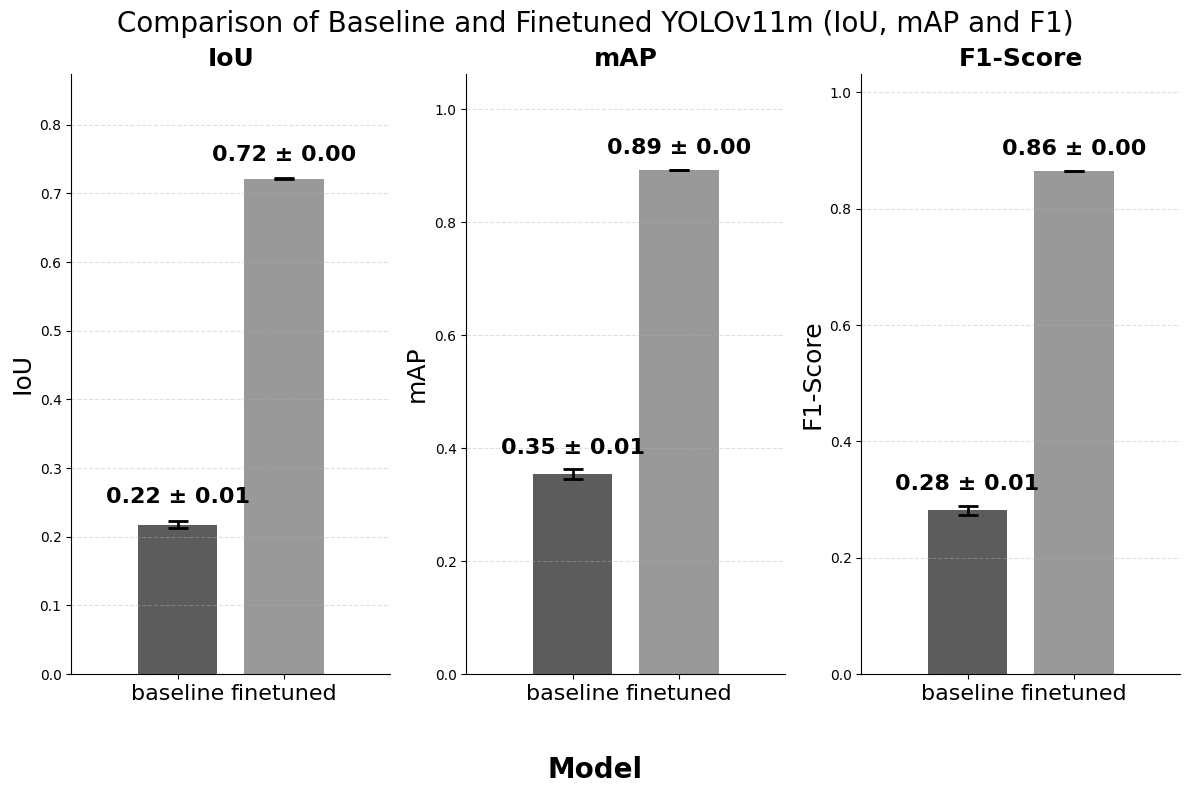

In [34]:
fig = plot_bar_comparison(
    results=results,
    figsize=(12, 8),                 # Adjust this to control the spread of points
)

# Save the figure if needed
fig.savefig('plot_bar_comparison_new.png', dpi=300, bbox_inches='tight')

# Display the figure
plt.show()

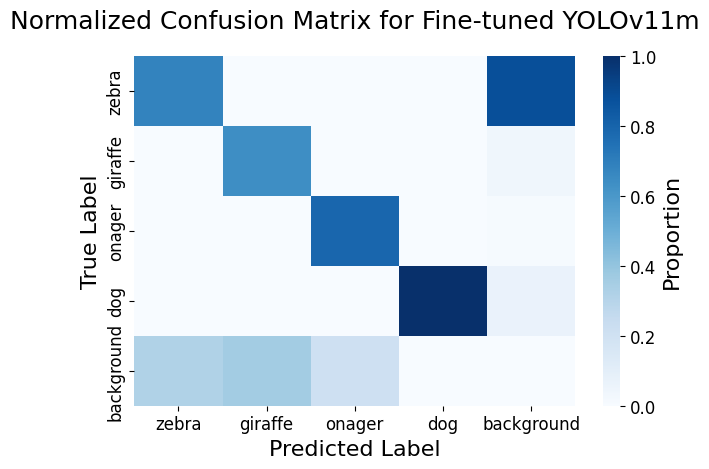

In [35]:
# plot CM 
# og plot: /fs/ess/PAS2136/Kenya-2023/yolo_benchmark/HerdYOLO/runs/detect/train4/confusion_matrix_normalized.png

cm = [[0.68, 0, 0, 0, 0.88],
      [0, 0.64, 0, 0, 0.04],
      [0, 0, 0.79, 0, 0.01],
      [0, 0, 0, 1.0, 0.07],
      [0.32, 0.36, 0.21, 0, 0]]

row = ['zebra', 'giraffe', 'onager', 'dog', 'background']
col = ['zebra', 'giraffe', 'onager', 'dog', 'background']
df_cm = pd.DataFrame(cm, index=row, columns=col)

# Create heatmap without annotations and with colorbar
sns.heatmap(df_cm, 
            annot=False,  # Remove numbers from grid
            cmap='Blues', 
            cbar=True,    # Add colorbar
            cbar_kws={'label': 'Proportion'})  # Label for colorbar

# Increase font sizes
plt.title("Normalized Confusion Matrix for Fine-tuned YOLOv11m", fontsize=18, pad=20)
plt.xlabel("Predicted Label", fontsize=16)
plt.ylabel("True Label", fontsize=16)

# Increase tick label sizes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Adjust colorbar label font size
cbar = plt.gca().collections[0].colorbar
cbar.ax.tick_params(labelsize=12)
cbar.set_label('Proportion', fontsize=16)

plt.tight_layout()
plt.show()